In [64]:
from lstd import *
from q_learning import *
import numpy as np
from typing import List, Tuple
from utils import *
from itertools import product
from scipy.optimize import minimize

># Model Definition

In [65]:
THETA   = 1/2
KAPPA   = 1/2
OMEGA_A = 0.1
OMEGA_U = 0.1
GAMMA_U = 0.9
BETA_U  = 0.1 
BETA_A  = 0.1 
ALPHA_U = 1
SIGMA_D = 1
LAMBDA  = 1

In [66]:
A = np.array([
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, THETA, THETA - KAPPA],
        [0, 0, 0, 1 - OMEGA_A, 0],
        [0, 0, 0, 0, 1 - OMEGA_U]])
B = np.array([1, GAMMA_U, (THETA - KAPPA) * GAMMA_U, 0, OMEGA_U * BETA_U])

Sigma_x = np.array([
    [0, 0, 0, 0, 0], 
    [0, SIGMA_D**2, THETA*SIGMA_D**2, 0, 0],
    [0, THETA*SIGMA_D**2, THETA**2*SIGMA_D**2, 0, 0],
    [0, 0, 0, BETA_A**2, 0],
    [0, 0, 0, 0, 0]])

Q = np.array([
    [LAMBDA*SIGMA_D**2, 0, 0, -1/2, -1/2], 
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [-1/2, 0, 0, 0, 0],
    [-1/2, 0, 0, 0, 0]])
S = np.array([
    [LAMBDA*THETA*SIGMA_D**2 - GAMMA_U/2, 0, 0, -THETA/2, -(THETA - KAPPA)/2]])

R = np.array([[LAMBDA*THETA**2*SIGMA_D**2 - (THETA - KAPPA)*GAMMA_U]])
C = np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0]])
L = np.block([[Q, S.T], [S, R]])

We will re-utilize the LQR gain obtained previously

In [67]:
K_star = np.array([0.85724945,  0.,          0.,         -0.40135333, -0.38022947])

># Prerequisite

We first define the helper functions

In [68]:
def LQR_policy(x: np.ndarray) -> np.ndarray:
    return -K_star @ x

In [69]:
def simulate_linear_model(x0: np.ndarray, policy : callable, n_step : int, with_noise : bool = False) -> Tuple[np.ndarray, np.ndarray]:

    x = np.zeros((5, n_step))
    u = np.zeros((1, n_step-1))

    x[:,0] = x0

    for i in range(n_step-1):

        u[:, i] = policy(x[:,i])
        
        if with_noise:
            x[:,i+1] = A @ x[:,i] + B * u[:, i] + np.random.multivariate_normal(np.zeros(5), Sigma_x)
        else:
            x[:,i+1] = A @ x[:,i] + B * u[:, i]

    return (x, u)


def simulate_nl_model(x0: np.ndarray, policy : callable, n_step : int, with_noise : bool = False, var = 1) -> Tuple[np.ndarray, np.ndarray]:

    x = np.zeros((5, n_step))
    u = np.zeros((1, n_step-1))

    x[:,0] = x0

    for i in range(n_step-1):

        I = x[0,i]
        x_a = x[3,i]
        x_u = x[4,i]

        # Control input based on the LQG controller
        u[:, i] = policy(x[:, i])
     
        # Update state 
        F = np.array([
            I + u[0, i],
            x_a + x_u + GAMMA_U* u[0, i] + ALPHA_U * u[0, i] * x_u,
            THETA * x_a + (THETA - KAPPA) * x_u + (THETA - KAPPA) * GAMMA_U * u[0, i] + (THETA - KAPPA) * ALPHA_U * u[0, i] * x_u,
            (1 - OMEGA_A) * x_a,
            (1 - OMEGA_U) * x_u + OMEGA_U * BETA_U * u[0, i]
        ])

        if with_noise:
            xi_d = np.random.normal(0, var)
            xi_a = np.random.normal(0, var)

            xi = np.array([0, SIGMA_D*xi_d, THETA*SIGMA_D*xi_d, BETA_A*xi_a, 0]).reshape(-1)

            x[:, i+1] = F + xi
        else:
            x[:, i+1] = F

    return (x, u)

># LSTD Method

#### Defining the basis functions, the cost function and the LSTD algorithm

In [70]:
def generate_psi_quadratic(x, u):
    if not np.isscalar(u):
        u = u[0]
        
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    x5 = x[4]
    psi = [x1, x2, x3, x4, x5, u, x1**2, x2**2, x3**2, x4**2, x5**2, u**2, x1*u, x2*u, x3*u, x4*u, x5*u,\
             x1*x2, x1*x3, x1*x4, x1*x5, x2*x3, x2*x4, x2*x5, x3*x4, x3*x5, x4*x5]
    


    return np.array(psi)

In [71]:
def cost(x: np.ndarray, u: np.ndarray) -> float:
    if np.isscalar(u):
        u = np.array([u])
        
    return np.concatenate((x, u)) @ L @ np.concatenate((x, u))

#### Define the Q-function in the basis $\psi$

In [72]:
# Q-function
Q_lstd = lambda x, u, theta : generate_psi_quadratic(x, u) @ theta

#### Generating training data for LSTD, using the linear model (without noise)

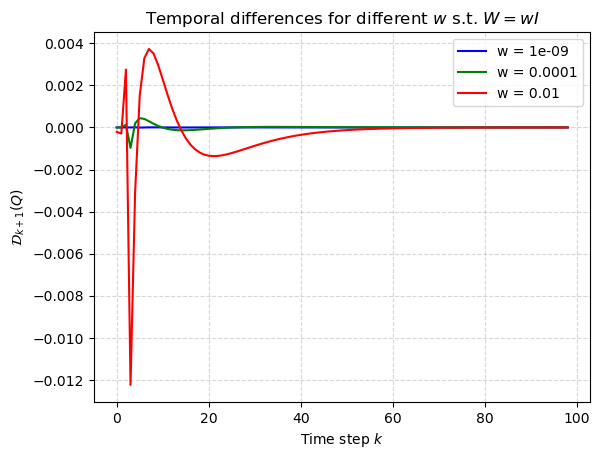

In [73]:
n_step = 100

x0 = [0, 2, 2, 2, 5]

data_linear = simulate_nl_model(x0, LQR_policy, n_step, with_noise=False)

val_W = np.array([1e-9,1e-4,1e-2])
temporal_differences = np.zeros((len(val_W), n_step-1))
theta_lstd_lin_arr = np.zeros((len(val_W), 27))

for i in range(len(val_W)):
    W = np.eye(27) * val_W[i]
    theta_lstd_lin = perform_lstd(LQR_policy, cost, generate_psi_quadratic, W, data=data_linear, d=27)
    # theta_lstd_lin = perform_lstd_PI(LQR_policy, cost, generate_psi_quadratic, W, data=data_linear, n_iter = 10, d = 27, action_space=(-5, 5))
    theta_lstd_lin_arr[i] = theta_lstd_lin
    for j in range(n_step-1):
        x = data_linear[0][:, j]
        u = data_linear[1][:, j]
        x_next = data_linear[0][:, j+1]
    
        temporal_differences[i,j] = cost(x, u) + Q_lstd(x_next, LQR_policy(x_next), theta_lstd_lin) - Q_lstd(x, u[0], theta_lstd_lin)

colors = ['b', 'g', 'r']
for i in range(len(val_W)):
    plt.plot(temporal_differences[i], color=colors[i], label='w = ' + str(val_W[i]))
plt.legend()
plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.title('Temporal differences for different $w$ s.t. $W=wI$')
plt.grid(linestyle='--', alpha = 0.5)
plt.show()

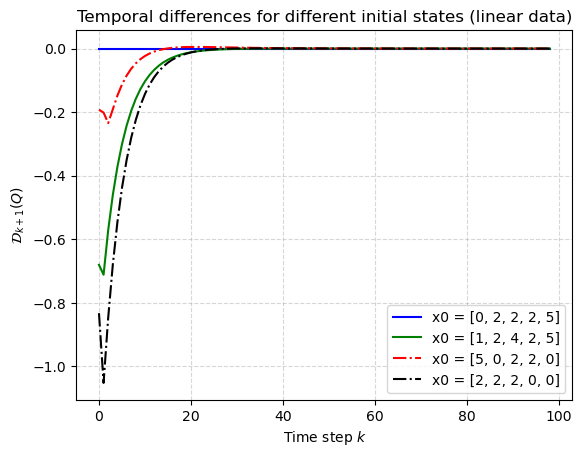

In [74]:
x0_arr = [[0, 2, 2, 2, 5], [1, 2, 4, 2, 5], [5, 0, 2, 2, 0], [2, 2, 2, 0, 0]]
W = 10 * np.eye(27)
n_step = 100
temporal_differences = np.zeros((len(x0_arr), n_step-1))

for i, x0 in enumerate(x0_arr):
    data_linear = simulate_linear_model(x0[0], LQR_policy, n_step, with_noise=False)
    theta_lstd_lin = perform_lstd(LQR_policy, cost, generate_psi_quadratic, W, data=data_linear, d=27)
    # theta_lstd_lin = perform_lstd_PI(LQR_policy, cost, generate_psi_quadratic, W, data=data_linear, n_iter = 10, d = 27, action_space=(-5, 5))
    Q_lstd = lambda x, u, theta : generate_psi_quadratic(x, u) @ theta

    for j in range(n_step-1):
        x = data_linear[0][:, j]
        u = data_linear[1][:, j]
        x_next = data_linear[0][:, j+1]
    
        temporal_differences[i,j] = cost(x, u) + Q_lstd(x_next, LQR_policy(x_next), theta_lstd_lin) - Q_lstd(x, u[0], theta_lstd_lin)
    

colors = ['b', 'g', 'r', 'black']
linestyles = ['-', '-', '-.', '-.']
for i in range(len(x0_arr)):
    plt.plot(temporal_differences[i], color=colors[i], label='x0 = ' + str(x0_arr[i]), linestyle=linestyles[i])
plt.legend()
plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.title('Temporal differences for different initial states (linear data)')
plt.grid(linestyle='--', alpha = 0.5)
plt.show()

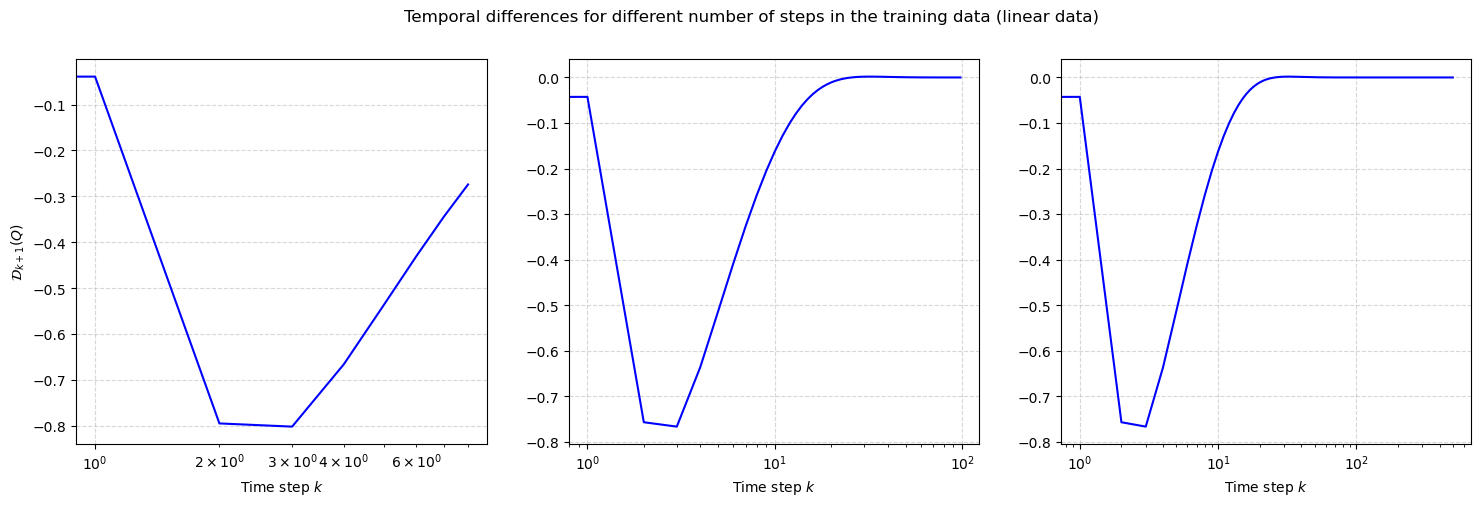

In [75]:
n_steps_arr = [10, 100, 500]
x0 = [0, 2, 2, 2, 5]
temporal_differences = []

for i, n_step in enumerate(n_steps_arr):
    data_linear = simulate_linear_model(x0, LQR_policy, n_step, with_noise=False)
    theta_lstd_lin = perform_lstd(LQR_policy, cost, generate_psi_quadratic, W, data=data_linear, d=27)
    Q_lstd = lambda x, u, theta : generate_psi_quadratic(x, u) @ theta

    td = np.zeros(n_step-1)
    for j in range(n_step-1):
        x = data_linear[0][:, j]
        u = data_linear[1][:, j]
        x_next = data_linear[0][:, j+1]
    
        td[j] = cost(x, u) + Q_lstd(x_next, LQR_policy(x_next), theta_lstd_lin) - Q_lstd(x, u[0], theta_lstd_lin)
    temporal_differences.append(td)

# subplot de 1x3 
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i in range(len(n_steps_arr)):
    axs[i].semilogx(temporal_differences[i], color='b', label='n_step = ' + str(n_steps_arr[i]))
    axs[i].set_xlabel('Time step $k$')
    if i ==0:
        axs[i].set_ylabel('$\\mathcal{D}_{k+1}(Q)$')
    axs[i].grid(linestyle='--', alpha = 0.5)
fig.suptitle('Temporal differences for different number of steps in the training data (linear data)')
plt.show()

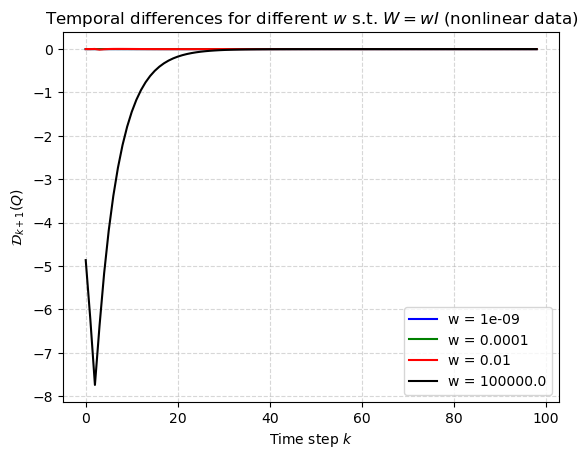

In [152]:
n_step = 100
x0 = [0, 2, 2, 2, 5]
data_nonlinear = simulate_nl_model(x0, LQR_policy, n_step, with_noise=False)

val_W = np.array([1e-9,1e-4,1e-2, 1e5])
temporal_differences = np.zeros((len(val_W), n_step-1))
theta_lstd_nl_arr = np.zeros((len(val_W), 27))

for i in range(len(val_W)):
    W = np.eye(27) * val_W[i]
    theta_lstd_nl = perform_lstd(LQR_policy, cost, generate_psi_quadratic, W, data=data_nonlinear, d=27)
    theta_lstd_nl_arr[i] = theta_lstd_nl
    for j in range(n_step-1):
        x = data_nonlinear[0][:, j]
        u = data_nonlinear[1][:, j]
        x_next = data_nonlinear[0][:, j+1]
    
        temporal_differences[i,j] = cost(x, u) + Q_lstd(x_next, LQR_policy(x_next), theta_lstd_nl) - Q_lstd(x, u[0], theta_lstd_nl)

colors = ['b', 'g', 'r', 'black']
for i in range(len(val_W)):
    plt.plot(temporal_differences[i], color=colors[i], label='w = ' + str(val_W[i]))
plt.legend()
plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.title('Temporal differences for different $w$ s.t. $W=wI$ (nonlinear data)')
plt.grid(linestyle='--', alpha = 0.5)
plt.show()

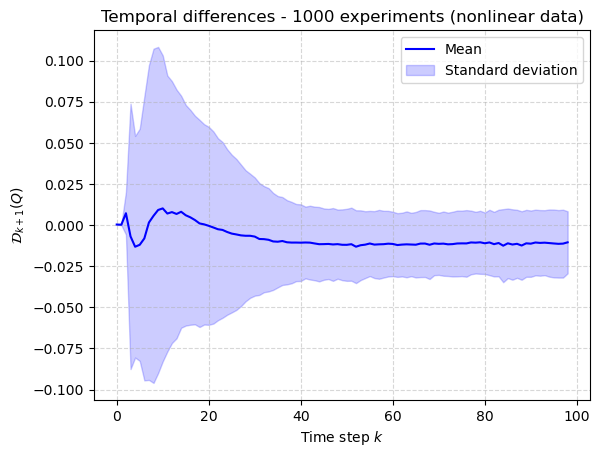

In [77]:
n_step = 100
x0 = [0, 2, 2, 2, 5]
n_simu = 1000
temporal_differences = np.zeros((n_simu, n_step-1))

for i in range(n_simu):
    data_nonlinear = simulate_nl_model(x0, LQR_policy, n_step, with_noise=True)
    theta_lstd_nl = perform_lstd(LQR_policy, cost, generate_psi_quadratic, W, data=data_nonlinear, d=27)
    for j in range(n_step-1):
        x = data_nonlinear[0][:, j]
        u = data_nonlinear[1][:, j]
        x_next = data_nonlinear[0][:, j+1]
    
        temporal_differences[i,j] = cost(x, u) + Q_lstd(x_next, LQR_policy(x_next), theta_lstd_nl) - Q_lstd(x, u[0], theta_lstd_nl)
    
plt.plot(np.mean(temporal_differences, axis=0), color='b', label = 'Mean')
plt.fill_between(range(n_step-1), np.mean(temporal_differences, axis=0) - np.std(temporal_differences, axis=0), np.mean(temporal_differences, axis=0) + np.std(temporal_differences, axis=0), color='b', alpha=0.2, label='Standard deviation')
plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.title('Temporal differences - 1000 experiments (nonlinear data)')
plt.grid(linestyle='--', alpha = 0.5)
plt.legend()
plt.show()

In [78]:
def policy_lstd_lin(x: np.ndarray) -> np.ndarray:
    res = minimize(lambda u: Q_lstd(x, u, theta_lstd_lin), 1, bounds=[(-5, 5)])
    return res.x # return the best action

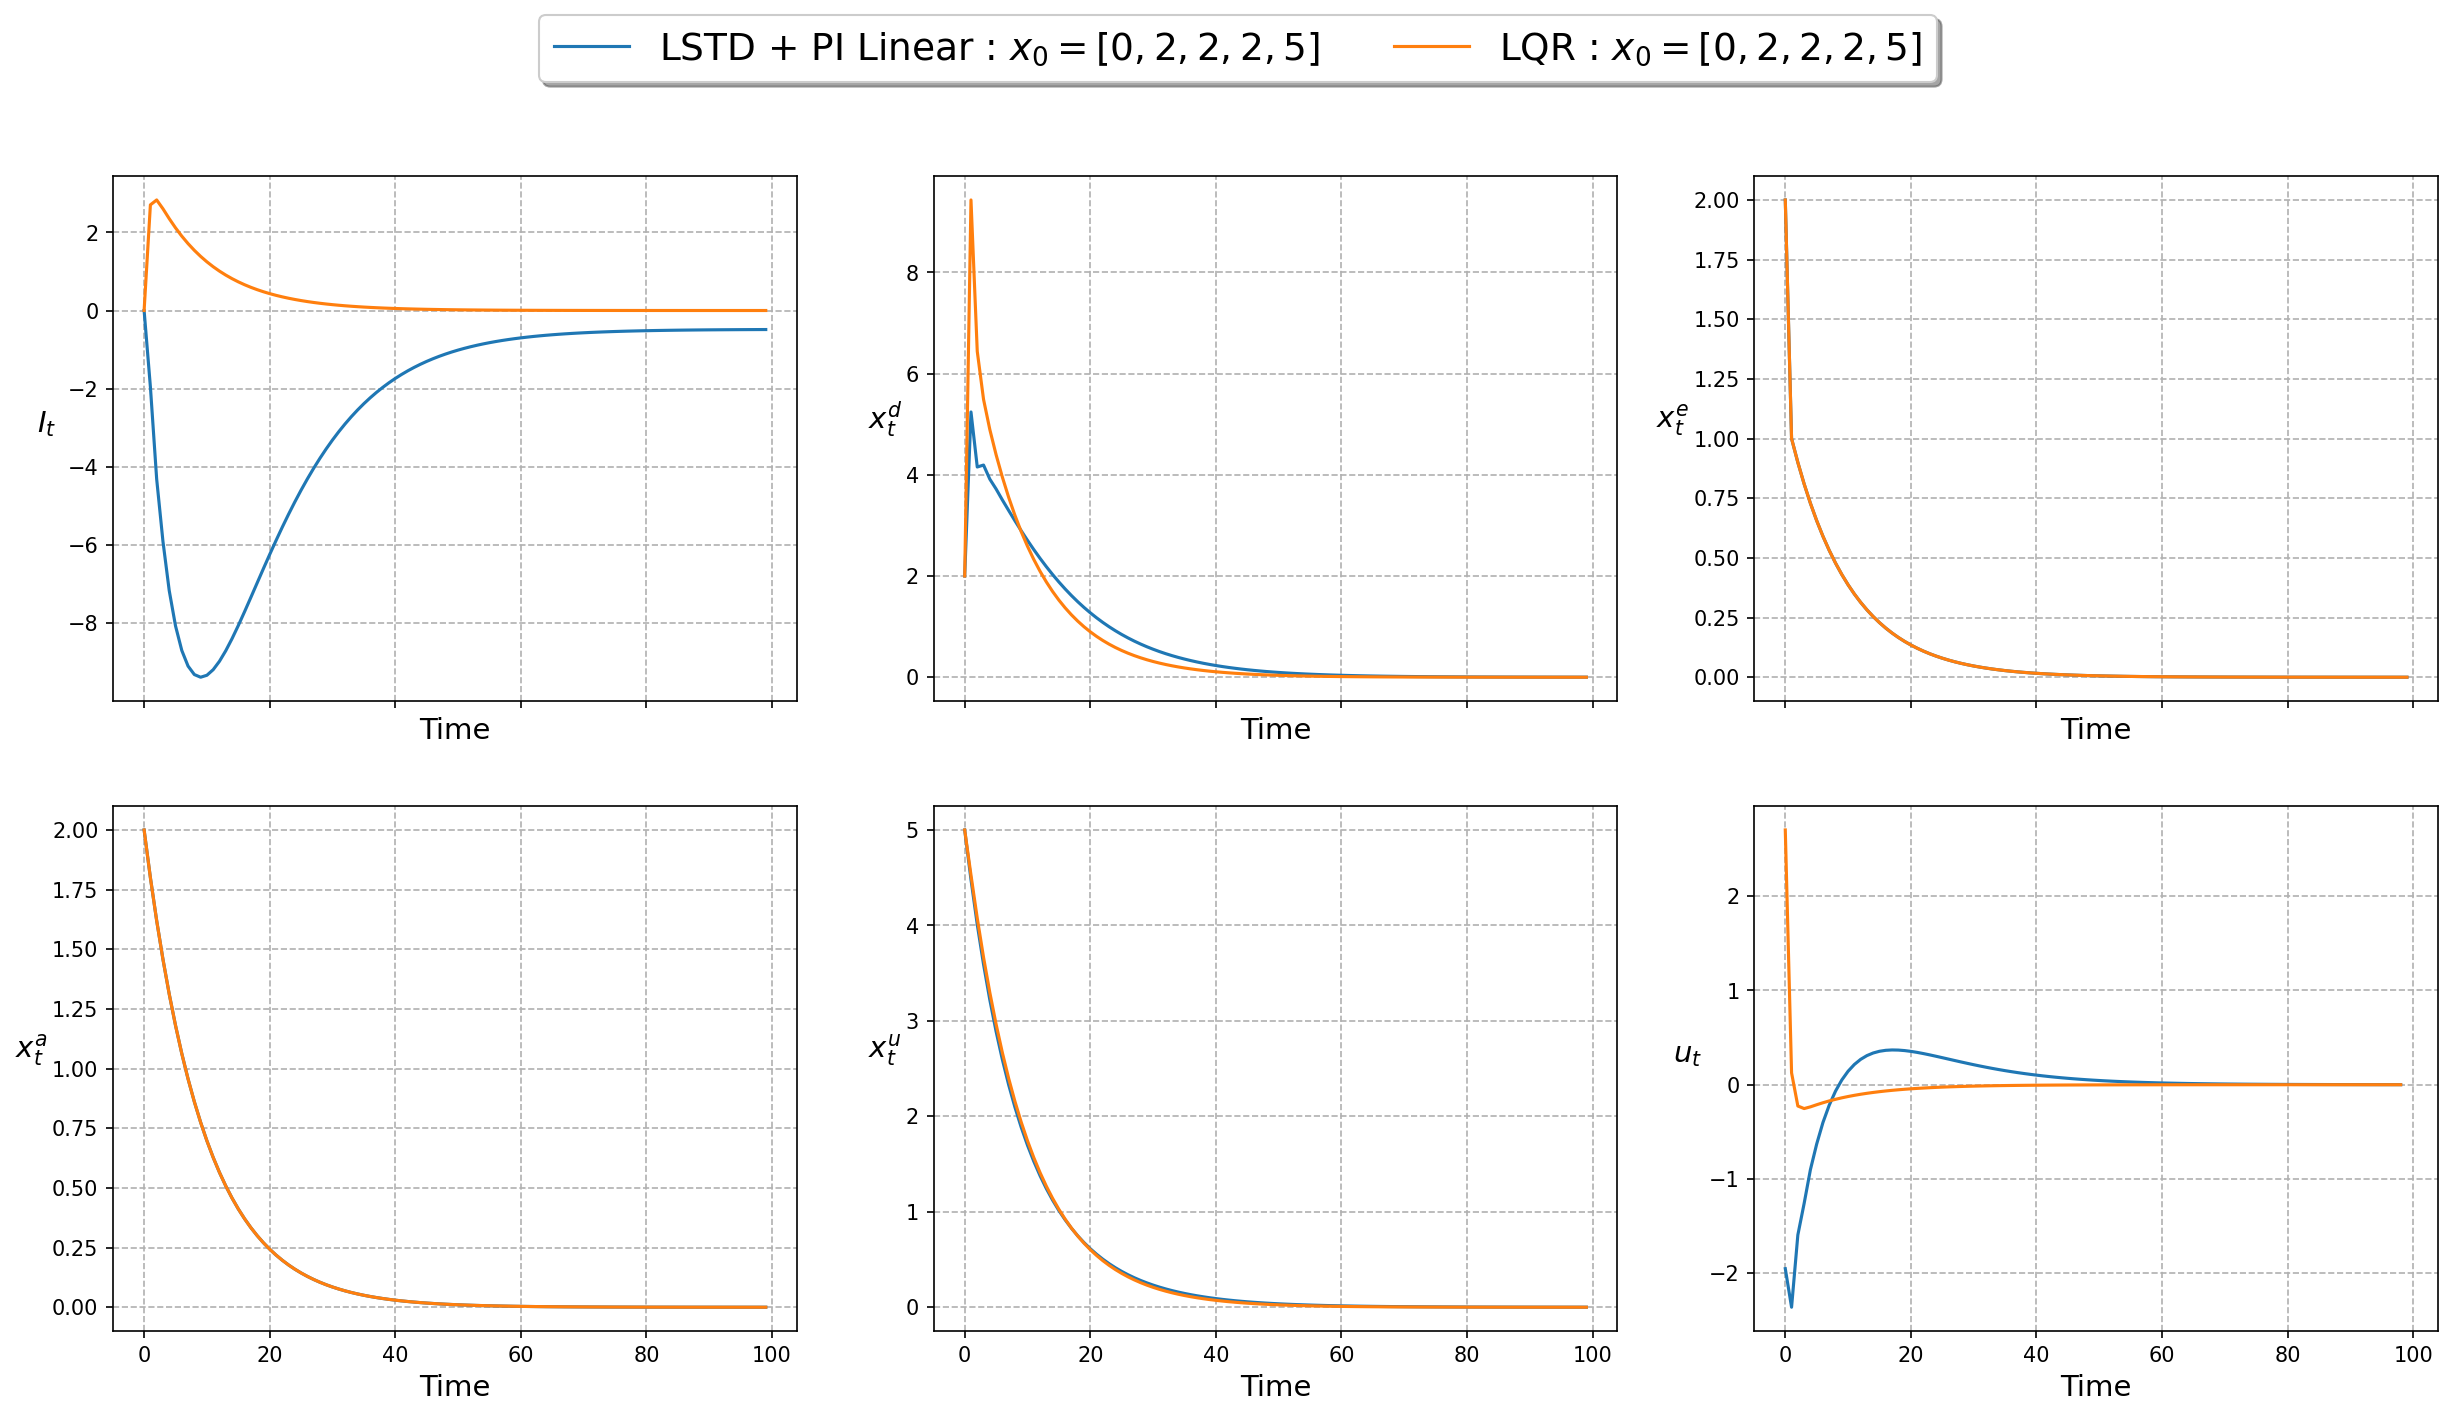

In [ ]:
n_step = 100
data_linear = simulate_linear_model(x0, LQR_policy, n_step, with_noise=False)

theta_lstd_PI_lin = perform_lstd_PI(LQR_policy, cost, generate_psi_quadratic, W = 10**(5) * np.eye(27), data=data_linear, d=27, action_space=(-20, 20), n_iter = 10)
theta_lstd_lin = perform_lstd(LQR_policy, cost, generate_psi_quadratic, W = 10**(5) * np.eye(27), data=data_linear, d=27)

def policy_lstd_PI_lin(x: np.ndarray) -> np.ndarray:
    res = minimize(lambda u: Q_lstd(x, u, theta_lstd_PI_lin), 1, bounds=[(-20, 20)])
    return res.x # return the best action

def policy_lstd_lin(x: np.ndarray) -> np.ndarray:
    res = minimize(lambda u: Q_lstd(x, u, theta_lstd_lin), 1, bounds=[(-20, 20)])
    return res.x # return the best action

x_lstd_PI, u_lstd_PI  = simulate_linear_model(x0, policy_lstd_lin, n_step, with_noise=False)
x_lstd, u_lstd = simulate_linear_model(x0, policy_lstd_PI_lin, n_step, with_noise=False)
x_lqr, u_lqr = data_linear

show_trajectories([[x_lstd], [x_lqr], [x_lstd_PI]], [[u_lstd], [u_lqr], [u_lstd_PI]], [x0, x0], ['LSTD Linear',"LQR", 'LSTD + PI Linear'])